# Noise Model Analysis

<b>In the notebook, we analyze normal, SC, and noise in transition or Melange 1% using prior knowledge of TES parameters from 
the dIdV analysis from https://github.com/spice-herald/detprocess/blob/noise_sim/examples/iv_didv/didv_analysis.ipynb </b>


  1. <font color="blue"><b>Extract SQUID+Electronics noise from normal noise</b></font>
      * We use data taken during and IV Sweep
      * We do not fit normal noise but instead extract the SQUID noise by subtracting the Johnson noise from Rload and Rn
      * Alternatively, we can actually fit the normal noise to get SQUID noise using the following model: <br><b>(squiddc*(1.0+(squidpole/f)**squidn))**2.0</b> <br>with
        * "squiddc" : The DC value of the SQUID and downstream electronics noise, in Amps/rtHz. 
        * "squidpole" : The frequency pole for the SQUID and downstream electronics
        * "squidn" : The power of the SQUID and downstream electronics noise, in Hz. <br><br>
        
  2. <font color="blue"><b>Calculate and Fit PSD SC noise</b></font>
      *  We use data taken during and IV Sweep
      *  Fit the components of the SC Noise and get in particular Tload<br><br>
  
  3. <font color="blue"><b>Calculate and Analyze PSD noise in transition </b></font>
      * We use the same continuous data that was used for BOR dIdV Analysis (see notebook demo) 
      * Prior fit of Normal and SC noise  is required
  

In [3]:
import qetpy as qp
import numpy as np
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
import pickle

# detprocess
from detprocess import Noise, NoiseModel, FilterData

### Channel  Name and Data Paths


In [4]:
channel_name = 'Melange1pc1ch'

# Normal noise path (for demo, we take normal/sc noise from a IV/dIdV sweep data taking)
normal_noise_path = '/sdata1/runs/run28/raw/iv_didv_I2_D20230615_T231959'
normal_noise_series = 'I2_D20230615_T232023'


# sc noise path 
sc_noise_path = '/sdata1/runs/run28/raw/iv_didv_I2_D20230615_T231959'
sc_noise_series = 'I2_D20230616_T022509'


# transition noise (from continuous data )
transition_noise_path = '/sdata1/runs/run28/raw/continuous_I2_D20230630_T193129'
transition_noise_series = 'I2_D20230630_T193742'


# didv analysis results produced by 
# demo: https://github.com/spice-herald/detprocess/blob/noise_sim/examples/iv_didv/didv_analysis.ipynb
# (from beginning of run dIdV of the above continuous data)
# The file also include IV sweep results
didv_file  = '/sdata1/runs/run28/filterdata/continuous_I2_D20230630_T193129/didv_analysis_D20240605_T184620.hdf5'


## Instantiate NoiseModel

In [5]:
noise_sim = NoiseModel()

##### Set BOR dIdV and IV sweep results

In [6]:
noise_sim.set_iv_didv_results_from_file(didv_file, channels=channel_name, poles=3)

# ALTERNATIVELY: IV/dIdV results can be set using dictionary

#filterdata = FilterData()
#filterdata.load_hdf5(file_name=didv_file)
#filterdata.describe()
#didv_results = filterdata.get_didv_results(channel_name, poles=3)
#ivsweep_results = filterdata.get_ivsweep_results(channel_name)
#noise_sim.set_iv_didv_results_from_dict(channel_name,
#                                        didv_results=didv_results, 
#                                        ivsweep_results=ivsweep_results)


INFO: Loading filter data from file /sdata1/runs/run28/filterdata/continuous_I2_D20230630_T193129/didv_analysis_D20240605_T184620.hdf5


##### Set Tbath 

In [7]:
# Let's use the  MC temperature from dIdV raw data and stored in didv results metadata 
# (taken from raw data)
didv_results = noise_sim.get_didv_results(channel_name, poles=2)

Tmc = didv_results['metadata']['temperature_mc']
print(f'MC Temperature = {Tmc*1000} mK')
noise_sim.set_tbath(Tmc)

MC Temperature = 7.120303809642792 mK


##### Set Tc

In [8]:
noise_sim.set_tc(channel_name, 48e-3)

##### Set TLoad guess

Tload is determined through as fit of SC noise. "TLoad guess" is starting point of the SC fit. We will used CP temperature where rshunt / sQUID card is located.

In [9]:
# set TLoad guess
# (taken from raw data)
Tcp = didv_results['metadata']['temperature_cp']
print(f'CP Temperature = {Tcp*1000} mK')
noise_sim.set_tload_guess(Tcp)

CP Temperature = 67.7054226398468 mK


##  Normal Noise Analysis

### Calculate Normal PSD

INFO: Found total of 1 raw data file(s) from 1 different series number!
INFO: Processing PSD for channel Melange1pc1ch
INFO: 985 events found in raw data for channel(s) Melange1pc1ch
INFO: Number of events after cuts = 405, efficiency = 41.12%


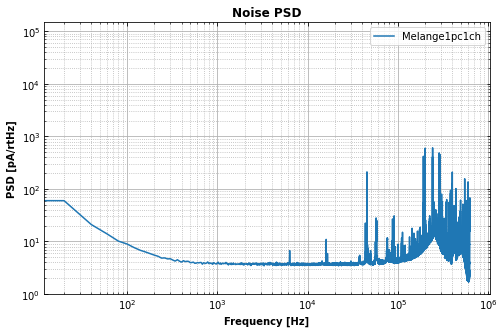

In [10]:
# Instantiate
normal_noise = Noise(verbose=True)

# set (or generate randoms if continuous data)
normal_noise.set_randoms(normal_noise_path, series=normal_noise_series)

# calculate psd and get array
normal_noise.calc_psd(channel_name, nevents=1000)
normal_psd, normal_psd_freqs = normal_noise.get_psd(channel_name)

# get data configuration
normal_noise_config = normal_noise.get_detector_config(channel_name)

# display
normal_noise.plot_psd(channel_name)

##### Set PSD

In [11]:
# Let's set normal noise psd (can be 2-sides, or folded)
noise_sim.set_psd(channel_name, normal_psd, normal_psd_freqs, 'normal')

#### Extract SQUID+Electronics noise from normal noise

In [12]:
noise_sim.calc_squid_noise(channels=channel_name,lgc_plot=True)

##  SC  Noise Analysis

Analysis requires to fit normal noise first (or set fit results)

### Calculate SC PSD

INFO: Found total of 1 raw data file(s) from 1 different series number!
INFO: Processing PSD for channel Melange1pc1ch
INFO: 968 events found in raw data for channel(s) Melange1pc1ch
INFO: Number of events after cuts = 645, efficiency = 66.63%


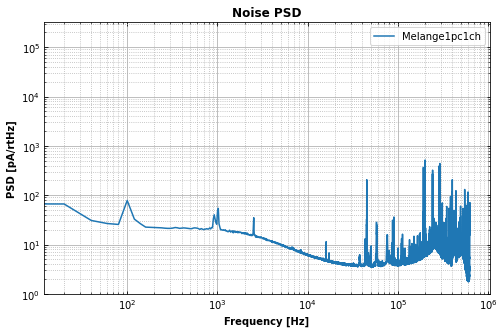

In [13]:
# Instantiate
sc_noise = Noise(verbose=True)

# set (or generate randoms if continuous data)
sc_noise.set_randoms(sc_noise_path, series=sc_noise_series)

# calculate psd and get array
sc_noise.calc_psd(channel_name, nevents=1000)
sc_psd, sc_psd_freqs = sc_noise.get_psd(channel_name)

# get data configuration
sc_noise_config = sc_noise.get_detector_config(channel_name)

# display
sc_noise.plot_psd(channel_name)

### Fit SC Noise to get Tload

##### Set PSD

In [14]:
# Let's set normal noise psd (can be 2-sides, or folded)
noise_sim.set_psd(channel_name, sc_psd, sc_psd_freqs, 'sc')

##### Fit

INFO: Fitted Tload from SC noise for channel Melange1pc1ch = 77.08 mK
Automatically determining G
P0 = 54.79799336174141 fW
G = 5.708124308514731e-12 W/K
Calculating dVdI
Calculating dPdI
Done calculating dVdI and dPdI


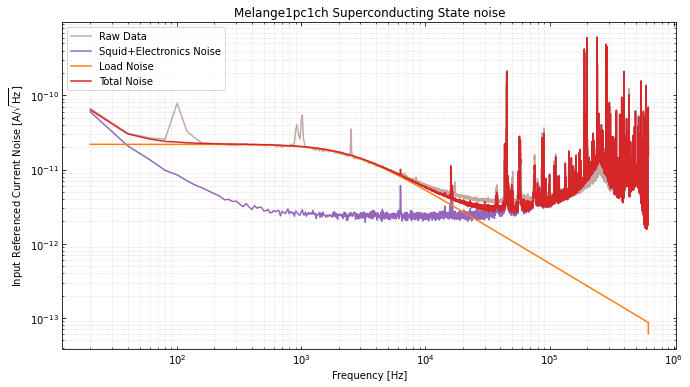

In [15]:
noise_sim.fit_sc_noise(channels=channel_name, fit_range=(100, 1e5), lgc_plot=True)

##  Transition Noise Analysis 

Analysis requires Normal and SC noise fit first

### Calculate Transition PSD from Continuous Data

INFO: Found total of 4 raw data file(s) from 1 different series number!
INFO: Found total of 4 files from 1 different series number!
INFO Node #1: Acquiring randoms for series I2_D20230630_T193742
INFO: Randoms acquisition done!
INFO: Processing PSD for channel Melange1pc1ch
INFO: 840 events found in raw data for channel(s) Melange1pc1ch
INFO: Number of events after cuts = 192, efficiency = 22.86%


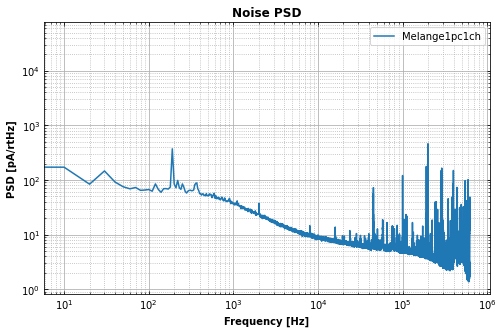

In [16]:
# Instantiate
t_noise = Noise(verbose=True)

# generate randoms
t_noise.generate_randoms(transition_noise_path, series=transition_noise_series, 
                         nevents=1000, ncores=1)

# calculate psd and get array
t_noise.calc_psd(channel_name, nevents=1000, 
                 trace_length_msec=100,
                 pretrigger_length_msec=50)

t_psd, t_psd_freqs = t_noise.get_psd(channel_name)

# get data configuration
t_noise_config = t_noise.get_detector_config(channel_name)

# display
t_noise.plot_psd(channel_name)

##### Set PSD

In [17]:
# Let's set normal noise psd (can be 2-sides, or folded)
noise_sim.set_psd(channel_name, t_psd, t_psd_freqs, 'transition')

##### Analyze noise

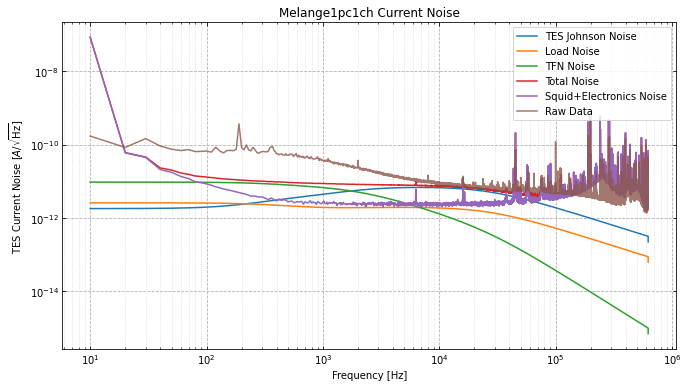

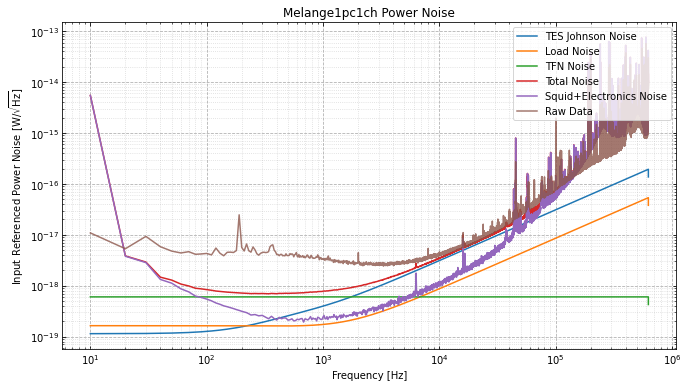

In [18]:
noise_sim.analyze_noise(channels=channel_name, lgc_plot=True)